# Step 1 Load the data

In [0]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, expr, dayofweek, weekofyear, date_format, asc, udf, lit, month
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
from pyspark.sql.types import IntegerType
import datetime
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import PipelineModel


In [0]:
# Specify Azure Blob Storage account details
storage_account_name = "qlintaxi"
storage_account_access_key = "pMMk6yCETTB5NBV4q4HT1Wor8G/oGClcBQ2MR0jBygsW0fb7F5fNfn001nlBj5G7OpIqSh1YSLzm+ASt4NoAwg=="
container_name = "taxi"

# Configure the Azure Blob Storage account credentials
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",
    storage_account_access_key
)

# Build the storage file path
taxi_file_path = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/clean_data.parquet"
# Read the Parquet data
taxi_df = spark.read.parquet(taxi_file_path)

In [0]:
#display(taxi_df)

# Step 2 Join the Data

In [0]:
# Get the Taxi Zone
zone_file_path = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/taxi-zone-lookup.csv"

# Read the CSV data
zone_df = spark.read.csv(zone_file_path, header=True, inferSchema=True)

In [0]:
# Join filtered weather data with df_2017_Jan_Feb on matching datetime values
final_df = taxi_df.join(zone_df, taxi_df.puLocationId == zone_df.LocationID)

# Drop the datetime column from the joined_df DataFrame
final_df = final_df.drop("puLocationId", "LocationID", "Borough")

In [0]:
from pyspark.sql.functions import year, month, dayofmonth, hour, to_timestamp
# Convert 'Date_Hour' from string to timestamp if it's not already
final_df = final_df.withColumn('Date_Hour', to_timestamp(col('Date_Hour'), 'yyyy-MM-dd\'T\'HH:mm:ss.SSSXXX'))

# Extract year, month, day, and hour from 'Date_Hour'
final_df = final_df.withColumn('Year', year(col('Date_Hour')))
final_df = final_df.withColumn('Month', month(col('Date_Hour')))
final_df = final_df.withColumn('Day', dayofmonth(col('Date_Hour')))
final_df = final_df.withColumn('Hour', hour(col('Date_Hour')))

# Sort the DataFrame by Date_Hour in ascending order
final_df = final_df.orderBy('Date_Hour')


In [0]:
#display(final_df)

# Step 3 Modeling

## 3.1 Train/Valid/Test Split

In [0]:

# Ensure the DataFrame is ordered by time
final_df = final_df.orderBy("Date_Hour")

# Calculate split dates
total_rows = final_df.count()
train_split_index = int(total_rows * 0.7)
val_split_index = train_split_index + int(total_rows * 0.15)

# Use Window function to assign row numbers
windowSpec = Window.orderBy("Date_Hour")
final_df = final_df.withColumn("row_number", F.row_number().over(windowSpec))

# Find the dates corresponding to split indices
train_split_date = final_df.where(col("row_number") == train_split_index).select("Date_Hour").collect()[0]["Date_Hour"]
val_split_date = final_df.where(col("row_number") == val_split_index).select("Date_Hour").collect()[0]["Date_Hour"]

# Remove the temporary column
final_df = final_df.drop("row_number")


In [0]:
# Split the data
train_data = final_df.where(col("Date_Hour") <= train_split_date)
validation_data = final_df.where((col("Date_Hour") > train_split_date) & (col("Date_Hour") <= val_split_date))
test_data = final_df.where(col("Date_Hour") > val_split_date)

# Verify the splits by checking the min and max dates in each DataFrame
# train_data.select(F.min("Date_Hour"), F.max("Date_Hour")).show()
# validation_data.select(F.min("Date_Hour"), F.max("Date_Hour")).show()
# test_data.select(F.min("Date_Hour"), F.max("Date_Hour")).show()


In [0]:
# Indexing the 'Zone' column
zone_indexer = StringIndexer(inputCol='Zone', outputCol='ZoneIndexed')

# One-hot encoding the indexed 'Zone' column (optional depending on the model and size of the dataset)
zone_encoder = OneHotEncoder(inputCols=['ZoneIndexed'], outputCols=['ZoneVec'])

# Update the assembler with the new columns
assembler = VectorAssembler(
    inputCols=['Year', 'Month', 'Day', 'Hour', 'day_of_week', 'week_number', 'is_weekend', 'is_holiday', 'ZoneVec'],
    outputCol='features'
)


## 3.2 RF with Hyperopt

Step 1: Define the Search Space for Hyperopt

In [0]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, SparkTrials
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

def get_or_create_spark_session():
    return SparkSession.builder.getOrCreate()
spark = SparkSession.builder.getOrCreate()
# Define the search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'numTrees': hp.quniform('numTrees', 10, 100, 5),
    'maxBins': hp.quniform('maxBins', 16, 256, 16),  
    'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1), 
}

Step 2: Define the Objective Function for Hyperop

In [0]:
import mlflow

def objective(hyperparams):
    # Ensure MLflow is tracking to the correct experiment
    mlflow.set_experiment('/Users/zhaozhou.lyu@vanderbilt.edu/RF_Tuning')

    with mlflow.start_run(nested=True):
        # Log only the hyperparameters being tested
        mlflow.log_params(hyperparams)
        
        # Create and train the Random Forest model
        rfRegressor = RandomForestRegressor(
            featuresCol="features",
            labelCol="demand",
            maxDepth=int(hyperparams['max_depth']),
            maxBins=int(hyperparams['maxBins']),
            numTrees=int(hyperparams['numTrees']),
            minInstancesPerNode=int(hyperparams['minInstancesPerNode']),
            # You can add other Random Forest hyperparameters here
        )
       
       # Use the stages from before, just replace the XGBRegressor with new params
        pipeline = Pipeline(stages=[zone_indexer, zone_encoder, assembler, rfRegressor])
    
        # Train the model
        model = pipeline.fit(train_data)
        
        # Evaluate the model on the validation set
        val_predictions = model.transform(validation_data)
        evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="rmse")
        val_rmse = evaluator.evaluate(val_predictions)
        
        # Log the key metric
        mlflow.log_metric("validation_rmse", val_rmse)

    return {'loss': val_rmse, 'status': STATUS_OK}

Step 3: Run Hyperopt for Hyperparameter Tuning

In [0]:
import mlflow

mlflow.set_experiment('/Users/zhaozhou.lyu@vanderbilt.edu/RF_Tuning')

trials = Trials()
# Start a parent run for the hyperparameter tuning process
with mlflow.start_run(run_name='Hyperparameter Tuning Parent Run'):
    best_hyperparams = fmin(fn=objective, 
                            space=space, 
                            algo=tpe.suggest, 
                            max_evals=64, 
                            trials=trials)
    mlflow.log_params(best_hyperparams)  # Optionally log the best hyperparameters at the parent run level


2024/04/10 21:22:23 INFO mlflow.tracking.fluent: Experiment with name '/Users/zhaozhou.lyu@vanderbilt.edu/RF_Tuning' does not exist. Creating a new experiment.


  0%|          | 0/128 [00:00<?, ?trial/s, best loss=?]

exception while intercepting server message: {'jsonrpc': '2.0', 'id': '18c1c553-f940-47f8-90d8-554a347b9a60', 'method': 'textDocument/codeAction', 'params': {'textDocument': {'uri': '/notebook/2154839837908356'}, 'range': {'start': {'line': 214, 'character': 0}, 'end': {'line': 214, 'character': 2}}, 'context': {'diagnostics': [{'range': {'start': {'line': 214, 'character': 0}, 'end': {'line': 214, 'character': 2}}, 'message': 'Undefined name `rm`', 'code': 'F821', 'data': {'codeLine': '#rm -rf /dbfs/tmp/xgboost/pipeline_001'}}]}}}
Traceback (most recent call last):
  File "/databricks/python_shell/dbruntime/lsp_backend/middleware/base.py", line 36, in intercept_message_to_server_safe
    return self.intercept_message_to_server(msg)
  File "/databricks/python_shell/dbruntime/lsp_backend/middleware/import_quickfix/import_quickfix.py", line 43, in intercept_message_to_server
    word = self._get_name(diagnostic)
  File "/databricks/python_shell/dbruntime/lsp_backend/middleware/import_qui

In [0]:
print(best_hyperparams)

Step 4: Train the Final Model and Evaluate on Test Data


In [0]:
# Combine training and validation sets for final model training
final_train_data = train_data.union(validation_data)

# Train the final model using the best hyperparameters found
best_hyperparams_rf = {
    'maxDepth': int(best_hyperparams['max_depth']),
    'maxBins': int(best_hyperparams['maxBins']),
    'numTrees': int(best_hyperparams['numTrees']),
    'minInstancesPerNode': int(best_hyperparams['minInstancesPerNode']),
}

# Re-create the model with the best hyperparameters
final_rfRegressor = RandomForestRegressor(
    featuresCol="features",  # Correct parameter name
    labelCol="demand",  # Correct parameter name
    maxDepth=best_hyperparams_rf['maxDepth'],  # Correct parameter name
    maxBins=best_hyperparams_rf['maxBins'],  # Correct parameter name
    numTrees=best_hyperparams_rf['numTrees'],  # Correct parameter name
    minInstancesPerNode=best_hyperparams_rf['minInstancesPerNode'],
)

final_pipeline = Pipeline(stages=[zone_indexer, zone_encoder, assembler, final_rfRegressor])

# Train the final model on the combined training and validation dataset
final_model = final_pipeline.fit(final_train_data)

# Evaluate the final model on the test set
test_predictions = final_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="rmse")
test_rmse = evaluator.evaluate(test_predictions)
print("Test RMSE:", test_rmse)

# Step 4 Model Saving

In [0]:
#%sh
#rm -rf /dbfs/tmp/xgboost/pipeline_001
#rm -rf /dbfs/tmp/xgboost/pipelineModel_001

In [0]:
# Save the pipeline that created the model
final_pipeline.save('pipeline_rf')
 
# Save the model itself
final_model.save('rffinetone_3')

In [0]:
loadedModel = PipelineModel.load("dbfs:/rffinetone_3/")

In [0]:
rfModel = loadedModel.stages[-1]

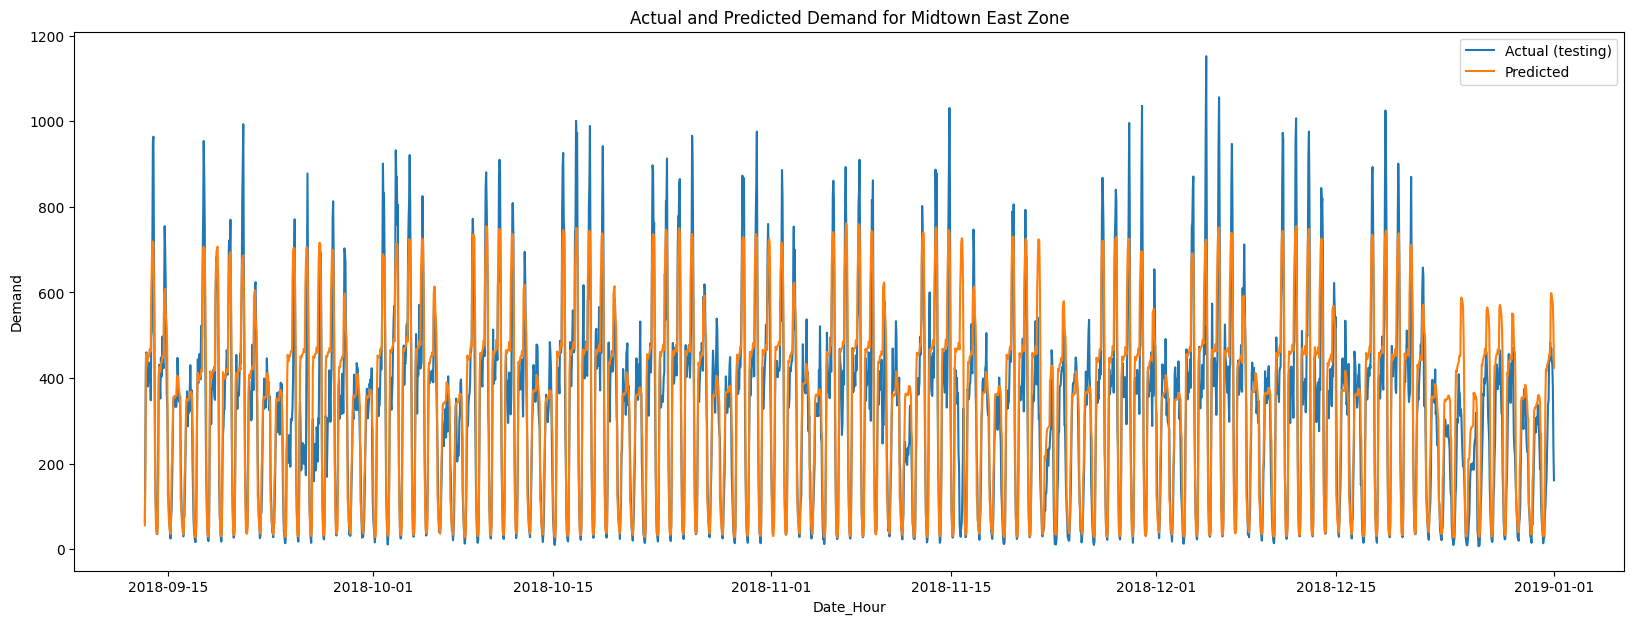

In [0]:
test_predictions = loadedModel.transform(test_data)

# Get the actual demand for training and validation set
train_actual_demand = train_data.filter(train_data.Zone == "Midtown East").select("Date_Hour", "demand").toPandas()
validation_actual_demand = validation_data.filter(validation_data.Zone == "Midtown East").select("Date_Hour", "demand").toPandas()
# Concatenate the training and validation data with the test predictions
training_data = pd.concat([train_actual_demand, validation_actual_demand])

# Get the predicted demand for the test set
testing_data = test_predictions.filter(test_predictions.Zone == "Midtown East").select("Date_Hour", "demand", "prediction").toPandas()



# Plot the graph
plt.figure(figsize=(20, 7))
#plt.plot(training_data["Date_Hour"], training_data["demand"], label="Actual (training)")
plt.plot(testing_data["Date_Hour"], testing_data["demand"], label="Actual (testing)")
plt.plot(testing_data["Date_Hour"], testing_data["prediction"], label="Predicted")
plt.xlabel("Date_Hour")
plt.ylabel("Demand")
plt.title("Actual and Predicted Demand for Midtown East Zone")
plt.legend()
plt.show()

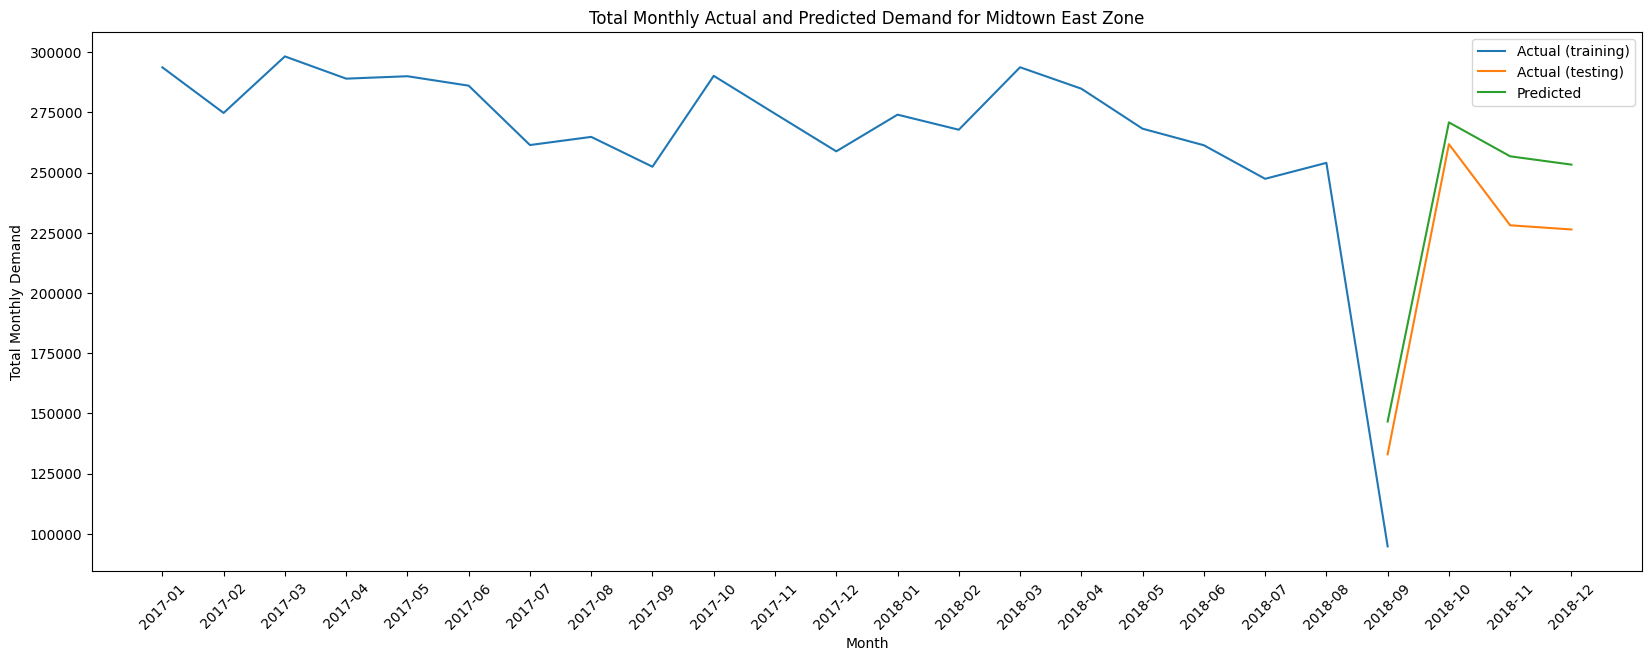

In [0]:
# Get the actual demand for training and validation set
train_actual_demand = train_data.filter(train_data.Zone == "Midtown East").select("Date_Hour", "demand").toPandas()
validation_actual_demand = validation_data.filter(validation_data.Zone == "Midtown East").select("Date_Hour", "demand").toPandas()

# Concatenate the training and validation data
training_data = pd.concat([train_actual_demand, validation_actual_demand])

# Transform your test_data with the trained model to get predictions
test_predictions = loadedModel.transform(test_data)
testing_data = test_predictions.filter(test_predictions.Zone == "Midtown East").select("Date_Hour", "demand", "prediction").toPandas()

# Convert the Date_Hour column to datetime
training_data['Date_Hour'] = pd.to_datetime(training_data['Date_Hour'])
testing_data['Date_Hour'] = pd.to_datetime(testing_data['Date_Hour'])

# Aggregate the demand and predictions by month
training_data['Month'] = training_data['Date_Hour'].dt.to_period('M')
testing_data['Month'] = testing_data['Date_Hour'].dt.to_period('M')

# Group by month and sum the demand
monthly_training_demand = training_data.groupby('Month')['demand'].sum()
monthly_testing_demand = testing_data.groupby('Month')['demand'].sum()
monthly_predictions = testing_data.groupby('Month')['prediction'].sum()

# Plot the graph
plt.figure(figsize=(20, 7))
plt.plot(monthly_training_demand.index.astype(str), monthly_training_demand.values, label="Actual (training)")
plt.plot(monthly_testing_demand.index.astype(str), monthly_testing_demand.values, label="Actual (testing)")
plt.plot(monthly_predictions.index.astype(str), monthly_predictions.values, label="Predicted")
plt.xlabel("Month")
plt.ylabel("Total Monthly Demand")
plt.title("Total Monthly Actual and Predicted Demand for Midtown East Zone")
plt.legend()
plt.xticks(rotation=45) # Rotate the x-axis labels for better readability
plt.show()
